# UCLA Results Validation

This notebook is aimed at attemping to cross validate the results achieved but UCLA in their paper. 
Cross validation is done here by diving the dataset into k splits, taking 1 split for training, one for testing and k - 2 for training k times. The cross validation will also be stratisfied in the protest class, making sure we have a decent balance between protest and non protest images in all splits

In [59]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
import h5py
import itertools
from lib import transforms

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
%reload_ext autoreload

### Loading up the data

In [11]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImages(source="UCLA")
len(imgs)


40720

Get the labels

In [12]:

cols = ["name", "label", "protest"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
split_tags = ['ucla-test', 'ucla-train']
imgs = imgs[cols + tag_cols + split_tags]
indx_non_violence = imgs['label'].isnull()

imgs.loc[:,tag_cols] = imgs.loc[:,tag_cols].astype(int)
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.209786,True,1,0,0,0,0,1,1,0,1,0,True,False
c7c6cecccc6ae6a4,test-00001.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
94c4c6443cbc9c14,test-00002.jpg,0.122890,True,1,0,0,0,0,0,0,0,0,0,True,False
f2f068703a38e869,test-00003.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
83a2860706c6e5e4,test-00004.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
1890151c5859c8f8,test-00005.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
7f5b59cbdc543c2c,test-00006.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
6264e0c0a0c0a0d0,test-00007.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
eee6e6e6c68f95b5,test-00008.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False


### Pre-processing

In [13]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
imgs.loc[indx_non_violence, "violence"] = -1
# df.loc[indx_non_violence, 'violence'] = -1

# masks the visual attributes that where image is not a protest
# for column, value in df.iloc[:,3:].iteritems(): # fill visual attributes with masking
#     df.loc[pd.isnull(df['protest']), column] = -1
imgs.loc[indx_non_violence, tag_cols] = -1
    
# fill nas
# df.fillna(0, inplace = True)

# df = imgs.rename(columns={"label": "violence"})
df = imgs
df

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.487873,True,1,0,0,0,0,1,1,0,1,0,True,False
c7c6cecccc6ae6a4,test-00001.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
94c4c6443cbc9c14,test-00002.jpg,0.285790,True,1,0,0,0,0,0,0,0,0,0,True,False
f2f068703a38e869,test-00003.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
83a2860706c6e5e4,test-00004.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
1890151c5859c8f8,test-00005.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
7f5b59cbdc543c2c,test-00006.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
6264e0c0a0c0a0d0,test-00007.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
eee6e6e6c68f95b5,test-00008.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False


In [14]:
i = df['violence'].idxmax()
df.loc[i]

name          test-03961.jpg
violence                   1
protest                 True
sign                       1
photo                      0
fire                       1
police                     0
children                   0
group_20                   1
group_100                  0
flag                       0
night                      0
shouting                   0
ucla-test               True
ucla-train             False
Name: a3a5e2a0d0d8a52c, dtype: object

Get the images

In [53]:
n_folds = 5
seed = 300

In [54]:
df_relevant = df[["name", "violence", "protest"] + tag_cols]
k_folds = au.getKSplitsStratified(df_relevant, n_folds, "protest", seed )
for i in k_folds:
    print("kfold has ", len(i[i["protest"] == True]), "protest images and ", len(i[i["protest"] == False]), "non protest images")

kfold has  2329 protest images and  5814 non protest images
kfold has  2329 protest images and  5814 non protest images
kfold has  2329 protest images and  5814 non protest images
kfold has  2329 protest images and  5814 non protest images
kfold has  2330 protest images and  5818 non protest images


In [55]:
# print first fold
k_folds[0]

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
b75c99623a6bcad9,train-17160.jpg,0.412834,True,1,0,0,0,0,1,1,0,0,0
7f3cac0ed29624aa,train-16341.jpg,0.505057,True,0,0,0,1,0,0,0,0,0,0
b639999581091513,train-12964.jpg,0.223537,True,1,0,0,0,0,1,0,0,0,0
397850f6e4caca2e,train-07695.jpg,0.275425,True,0,0,0,0,0,1,0,1,0,0
ecbdf0e4ed5d3d6d,train-27461.jpg,0.340665,True,1,0,0,0,0,0,0,1,0,0
597831a1a769cad2,test-00300.jpg,0.371559,True,1,0,0,0,0,1,0,0,0,0
80a6c69207060b09,train-19425.jpg,0.570133,True,0,0,1,0,0,0,0,0,0,0
de7a72664cc43624,test-07460.jpg,0.732520,True,0,0,1,0,0,0,0,0,0,0
478120a040cdb434,train-08125.jpg,0.346973,True,0,0,0,0,0,1,0,1,0,0


In [56]:
batch_size = 32

In [57]:

dummy_test_generator = au.ResizeSequence(
    df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


protest has shape (32,)  violence has shape (32,)  visual has shape (32, 10)


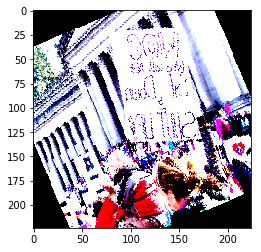

In [58]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
visual = first[1][2]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape, " visual has shape", visual.shape)

In [77]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 1000; patience = 10
optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)

In [80]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

In [75]:

k_folds_iter = itertools.cycle(k_folds) # will cycle through it

for i in range(n_folds):
    split_name = 'split' + str(i)
    
    # gets val and test folds
    val_fold = next(k_folds_iter)
    test_fold = next(k_folds_iter)
    
    # gets training fold
    train_fold = None
    for i in range(n_folds - 2): # by definition
        if (train_fold is None):
            train_fold = next(k_folds_iter)
        else:
            train_fold = train_fold.append(next(k_folds_iter))
            
    
    # build generators
    train_generator = au.ResizeSequence(
        train_fold,
        batch_size, 
        targets = ['protest', 'violence', tag_cols],
        transforms = [
            transforms.randomResizedCrop,
            transforms.randomRotation,
            transforms.randomHorizontalFlip,
            transforms.colorJitter,
            transforms.normalizeMinMax,
            transforms.lighting,
            transforms.normalizeStandardScore
        ]
    )
    validation_generator = au.ResizeSequence(
        val_fold,
        batch_size, 
        targets = ['protest', 'violence', tag_cols],
        transforms = [
            transforms.resize,
            transforms.centerCrop,
            transforms.normalizeMinMax,
            transforms.normalizeStandardScore
        ]
    )

            
    print(split_name, "train size ", len(train_fold), "val size ", len(val_fold), "test size ", len(test_fold))
    
    
    # Modeling start
    Kbackend.clear_session()
    
    model = au.initializeUCLAModel()
    
    
    model.compile(optimizer=optimizer,
              loss={'protest_out': Klosses.binary_crossentropy,
                    'visual_out': au.buildMaskedLoss(Klosses.binary_crossentropy, mask_value), 
                    'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value)},
              loss_weights={'protest_out': 1., 
                            'visual_out': 5, 
                            'violence_out': 10 })
    #model.summary()
    
    
    try:
    __file__ # Apparently, this is not defined in the notebook,
             # but it will be when we start running on the server
             # (So when things gets real)
    except NameError:
        __file__ = "test"
        
    
    name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name, split_name)
    model_checkout_path = "models/%s.hdf5" % name
    csv_logger_path = "logs/%s.csv" % name
    tensor_board_folder = os.path.join("logs", name)

    os.makedirs(tensor_board_folder)

    print("Writing model to: \t%s" % model_checkout_path)
    print("Writing log to: \t%s\n" % csv_logger_path)



    # callbacks
    change_lr = Kcallbacks.LearningRateScheduler(au.lrUpdateUCLA, 
                                                verbose = True)

    checkpoint = Kcallbacks.ModelCheckpoint(model_checkout_path,
                                           monitor='val_loss', 
                                           verbose=1,
                                           save_best_only=True,
                                           save_weights_only=False,
                                           mode='auto',
                                           period=1)

    earlystop = Kcallbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0, 
                                         patience=patience,
                                         verbose=1, 
                                         mode='auto')

    tensor_board = Kcallbacks.TensorBoard(log_dir=tensor_board_folder,
                                         histogram_freq=0,
                                         batch_size=32, 
                                         write_graph=True,
                                         write_grads=False, 
                                         write_images=False, 
                                         embeddings_freq=0,
                                         embeddings_layer_names=None,
                                         embeddings_metadata=None)

    csv_logger = Kcallbacks.CSVLogger(csv_logger_path, 
                                     separator=',', 
                                     append=False)
    
    history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger. earlystop])



split0 train size  24434 val size  8143 test size  8143
split1 train size  24434 val size  8143 test size  8143
split2 train size  24434 val size  8143 test size  8143
split3 train size  24434 val size  8143 test size  8143
split4 train size  24434 val size  8143 test size  8143
